In [62]:
!free -m

             total       used       free     shared    buffers     cached
Mem:        100721      75039      25681          0        282      12411
-/+ buffers/cache:      62345      38375
Swap:            0          0          0


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas
import numpy

In [3]:
train_data = pandas.read_csv('../data/data_train_Long.csv')
test_data = pandas.read_csv('../data/data_eval_Long.csv')

In [4]:
train_data.head()

,Unnamed: 0,Unnamed: 0.1,VeloCharge,BremPIDe,CaloNeutralPrs,CaloNeutralSpd,InAccBrem,InAccSpd,CaloPrsE,InAccPrs,...,piplus_OWNPV_XERR,piplus_OWNPV_YERR,piplus_OWNPV_ZERR,piplus_OWNPV_CHI2,piplus_OWNPV_NDOF,piplus_IP_OWNPV,piplus_IPCHI2_OWNPV,nCandidate,totCandidates,EventInSequence
0,0,167,0.997191,-0.553589,1.645630,1,1,1,17.279119,1,...,0.0107,0.0114,0.0637,39.704403,77,0.169319,0.454523,16,57,5
1,1,175,0.828652,-999.000000,-999.000000,-999,0,1,50.740273,1,...,0.0107,0.0114,0.0637,39.704403,77,0.178640,0.423664,24,57,5
2,2,1173,0.938202,-999.000000,-999.000000,-999,0,1,7.405337,1,...,0.0147,0.0147,0.0824,15.654854,37,10.851183,356.442937,20,51,33
3,3,1502,0.761938,-0.607507,3.291261,1,1,1,25.781544,1,...,0.0139,0.0124,0.0980,17.368431,51,0.066881,0.629366,12,28,49
4,4,1535,1.002809,-0.553589,32.364067,0,1,1,32.364067,1,...,0.0089,0.0086,0.0521,36.715508,105,0.055831,0.431035,3,105,52


In [5]:
signal_dict = {"Ghost": 0, "Electron": 11, "Muon": 13, "Pion": 211, "Kaon": 321, "Proton": 2212}
signal_dict_inverse = {0: "Ghost", 11: "Electron", 13: "Muon", 211: "Pion", 321: "Kaon", 2212: "Proton"}

In [6]:
def compute_labels_column(data, signal_dict):
    labels = numpy.abs(data.MCParticleType.values).astype(int)
    mask = numpy.zeros(len(labels), dtype=bool)
    for key, val in signal_dict.items():
        if key == 'Ghost':
            continue
        mask = mask | (labels == val)
    labels[~(mask)] = 0
    
    weights = numpy.ones(len(labels))
    for key, label in signal_dict.items():
        weights[labels == label] = 1. / sum(labels == label)
    return labels, weights

In [7]:
train_data['Signal'], train_data['Weight'] = compute_labels_column(train_data, signal_dict)
test_data['Signal'], test_data['Weight'] = compute_labels_column(test_data, signal_dict)

In [8]:
1. * sum(train_data.MCParticleType > 0) / len(train_data), 1. * sum(train_data.MCParticleType < 0) / len(train_data)

(0.4336716666666667, 0.4249733333333333)

In [9]:
def compute_charge(charge):
    charge_new = numpy.zeros(len(charge))
    charge_new[charge == 11] = -1
    charge_new[charge == 13] = -1
    charge_new[(charge == 321) | (charge == 211) | (charge == 2212)] = 1
    charge_new[charge == -11] = 1
    charge_new[charge == -13] = 1
    charge_new[(charge == -321) | (charge == -211) | (charge == -2212)] = -1
    return charge_new

In [10]:
train_data['Charge'] =  compute_charge(train_data.MCParticleType.values)
test_data['Charge'] = compute_charge(test_data.MCParticleType.values)

In [11]:
numpy.unique(train_data.Weight)

array([  1.29162254e-06,   5.87823817e-06,   7.23269758e-06,
         1.22024136e-05,   3.35131874e-05,   1.78253119e-04])

In [12]:
sum(train_data['Signal'] - abs(train_data.MCParticleType) != 0)

493

In [13]:
numpy.unique(train_data['Signal'])

array([   0,   11,   13,  211,  321, 2212])

In [14]:
for key, val in signal_dict.items():
    print key, sum(train_data.Signal == val)

Ghost 170119
Muon 29839
Pion 774220
Kaon 138261
Proton 81951
Electron 5610


# Acceptance features

In [15]:
features_acceptance = ['InAccSpd', 'InAccPrs', 'InAccBrem', 'InAccEcal', 'InAccHcal', 'InAccMuon']

In [16]:
correlation = numpy.corrcoef(train_data[features_acceptance].values.T)
correlation_test = numpy.corrcoef(test_data[features_acceptance].values.T)

In [17]:
print correlation
print correlation - correlation_test

[[ 1.          0.97794039  0.05313944  0.88014313  0.74279134  0.72432053]
 [ 0.97794039  1.          0.05254839  0.88205002  0.74474328  0.72476851]
 [ 0.05313944  0.05254839  1.          0.10249526  0.02635433 -0.07275792]
 [ 0.88014313  0.88205002  0.10249526  1.          0.81369528  0.72368345]
 [ 0.74279134  0.74474328  0.02635433  0.81369528  1.          0.82277701]
 [ 0.72432053  0.72476851 -0.07275792  0.72368345  0.82277701  1.        ]]
[[  0.00000000e+00  -3.53180940e-04  -3.18795732e-03  -7.50828280e-05
   -3.32208884e-04   6.99736592e-04]
 [ -3.53180940e-04   0.00000000e+00  -3.19023165e-03   6.07528939e-04
    5.53658339e-05   4.39345827e-04]
 [ -3.18795732e-03  -3.19023165e-03   0.00000000e+00  -3.34990261e-03
   -2.72611602e-03  -1.46935755e-03]
 [ -7.50828280e-05   6.07528939e-04  -3.34990261e-03   0.00000000e+00
    1.77839205e-04   1.08627245e-03]
 [ -3.32208884e-04   5.53658339e-05  -2.72611602e-03   1.77839205e-04
    0.00000000e+00   1.27964893e-03]
 [  6.99736592

In [18]:
def convert_DLL_to_LL(data, features):
    temp_data = data[features].values
    temp_data -= temp_data.max(axis=1, keepdims=True)
    temp_data = numpy.exp(temp_data)
    temp_data /= numpy.sum(temp_data, axis=1, keepdims=True)
    return pandas.DataFrame(temp_data, columns=map(lambda x: x + '_LL', features))

In [19]:
def compute_cum_sum_features(data, features, name="", scale=False):
    cum_sum = numpy.zeros(len(data))
    cum_features = {}
    for n, f in enumerate(features):
        temp = data[f].values
        if scale:
            temp = (temp - temp.mean()) / numpy.sqrt(temp.var())
        cum_sum += temp
        cum_features[name + str(n)] = cum_sum.copy()
    return pandas.DataFrame(cum_features, index=None)

In [20]:
def compute_cum_prod_features(data, features, name=""):
    cum_prod = numpy.ones(len(train_data))
    cum_features = {}
    for n, f in enumerate(features):
        cum_prod *= data[f].values
        cum_features[name + str(n)] = cum_prod.copy()
    return pandas.DataFrame(cum_features, index=None)

In [21]:
from sklearn.metrics import roc_auc_score
from collections import OrderedDict

def roc_auc_score_one_vs_all(labels, pred, signal_dict, sample_weight):
    rocs = OrderedDict()
    if len(pred.shape) == 1:
        pred = numpy.vstack([pred] * len(signal_dict.keys())).T
    print pred.shape
    for i, (key, label) in enumerate(signal_dict.items()):
        rocs[key] = [roc_auc_score(labels == label, pred[:, i], sample_weight=sample_weight)]
    return pandas.DataFrame(rocs)

In [22]:
def hist_features(data, labels, signal_dict, features, bins=30):
    for n, f in enumerate(features):
        subplot(len(features) // 3 + 1, 3, n+1)
        for key, val in signal_dict.items():
            temp_values = data[f].values
            temp_values = temp_values[numpy.array(labels) == val]
            hist(temp_values[temp_values > -200], label=key, alpha=0.2, normed=True, bins=bins)
        legend(loc='best')
        title(f)

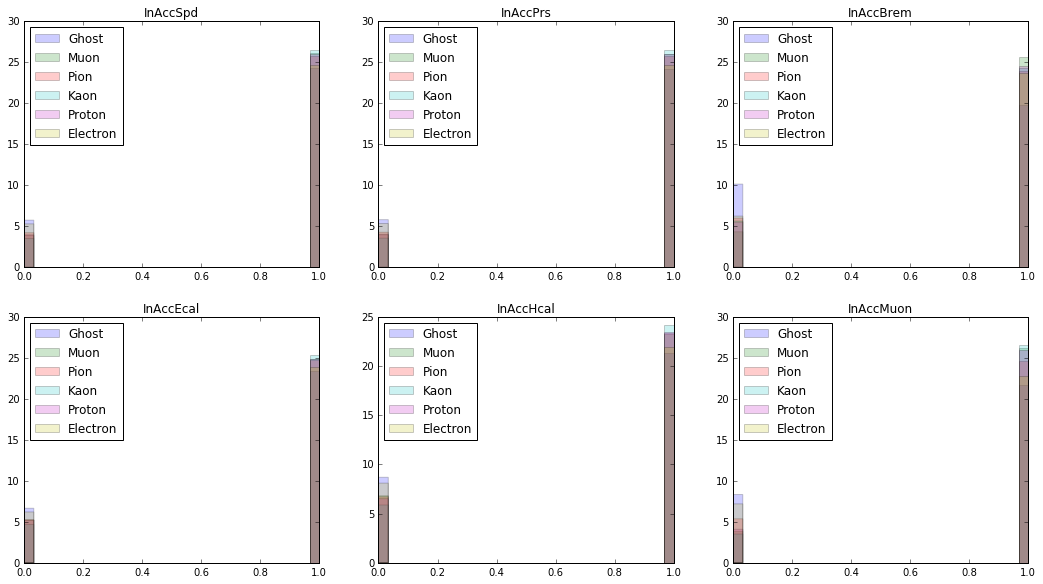

In [23]:
figure(figsize=(18, 15))
hist_features(train_data, train_data.Signal, signal_dict, features_acceptance)

In [24]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal.values, train_data[f].values, signal_dict, 
                                             train_data.Weight.values) for f in features_acceptance])
pd.index = features_acceptance
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
InAccSpd,0.473736,0.511217,0.504323,0.518523,0.509405,0.482798
InAccPrs,0.473689,0.510561,0.504482,0.518885,0.509268,0.483116
InAccBrem,0.423345,0.539526,0.506181,0.513444,0.516179,0.501325
InAccEcal,0.477551,0.506592,0.505570,0.517147,0.506589,0.486552
InAccHcal,0.468561,0.506112,0.508067,0.524824,0.511992,0.480444
InAccMuon,0.441223,0.530844,0.500381,0.537576,0.525956,0.464020


In [25]:
acceptance_cum_features = pandas.concat([compute_cum_sum_features(train_data, features_acceptance, 'acc_to_right_'),
                                         compute_cum_sum_features(train_data, features_acceptance[::-1], 'acc_to_left_')],
                                        axis=1)

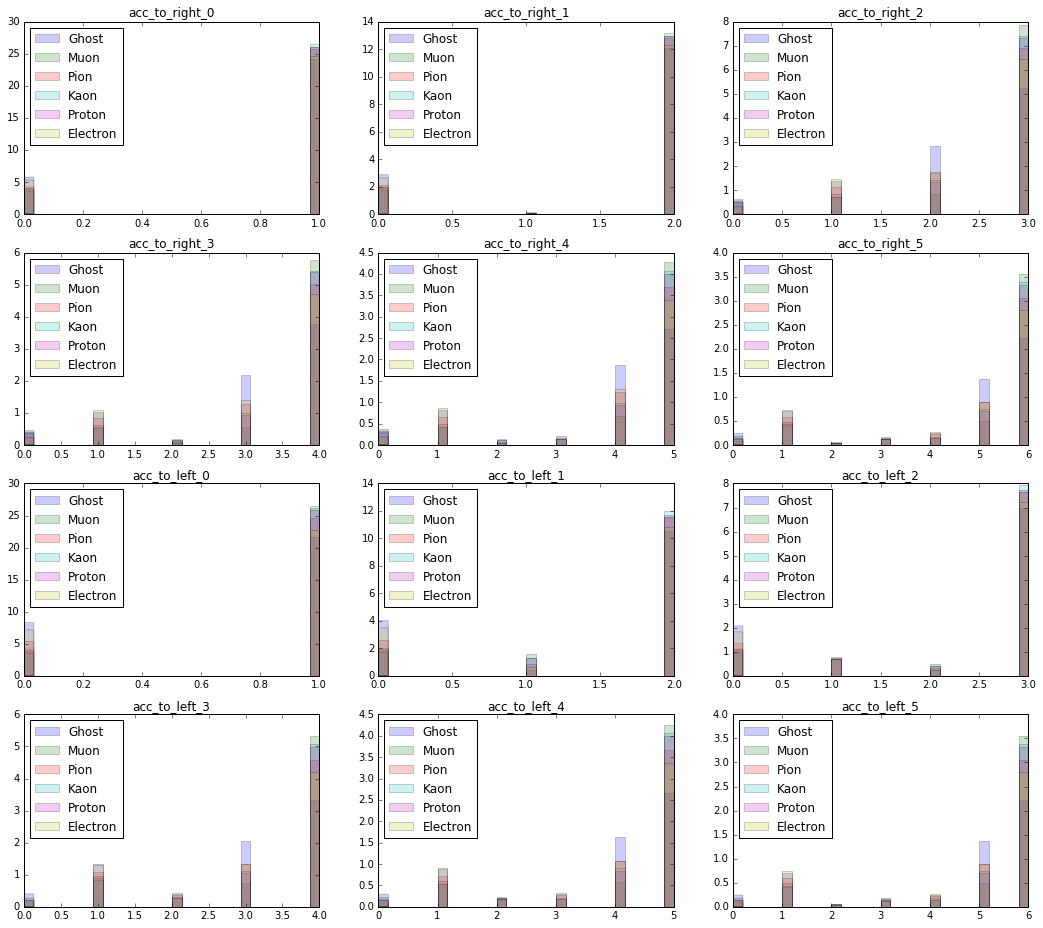

In [26]:
figure(figsize=(18, 20))
hist_features(acceptance_cum_features, train_data.Signal, signal_dict, acceptance_cum_features.columns)

In [27]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal.values, acceptance_cum_features[f].values, signal_dict, 
                                             train_data.Weight.values) for f in acceptance_cum_features.columns])
pd.index = acceptance_cum_features.columns
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
acc_to_right_0,0.473736,0.511217,0.504323,0.518523,0.509405,0.482798
acc_to_right_1,0.474156,0.510509,0.504523,0.518571,0.509043,0.483197
acc_to_right_2,0.408819,0.552088,0.503786,0.532546,0.526310,0.476451
acc_to_right_3,0.410078,0.551027,0.503822,0.533226,0.526061,0.475786
acc_to_right_4,0.408285,0.549285,0.504500,0.538059,0.528214,0.471656
acc_to_right_5,0.404733,0.551542,0.503208,0.541413,0.530669,0.468435
acc_to_left_0,0.441223,0.530844,0.500381,0.537576,0.525956,0.464020
acc_to_left_1,0.458502,0.513149,0.506298,0.530398,0.516764,0.474889
acc_to_left_2,0.461753,0.511936,0.506183,0.528287,0.514402,0.477439
acc_to_left_3,0.403661,0.551451,0.503624,0.541449,0.530817,0.468997


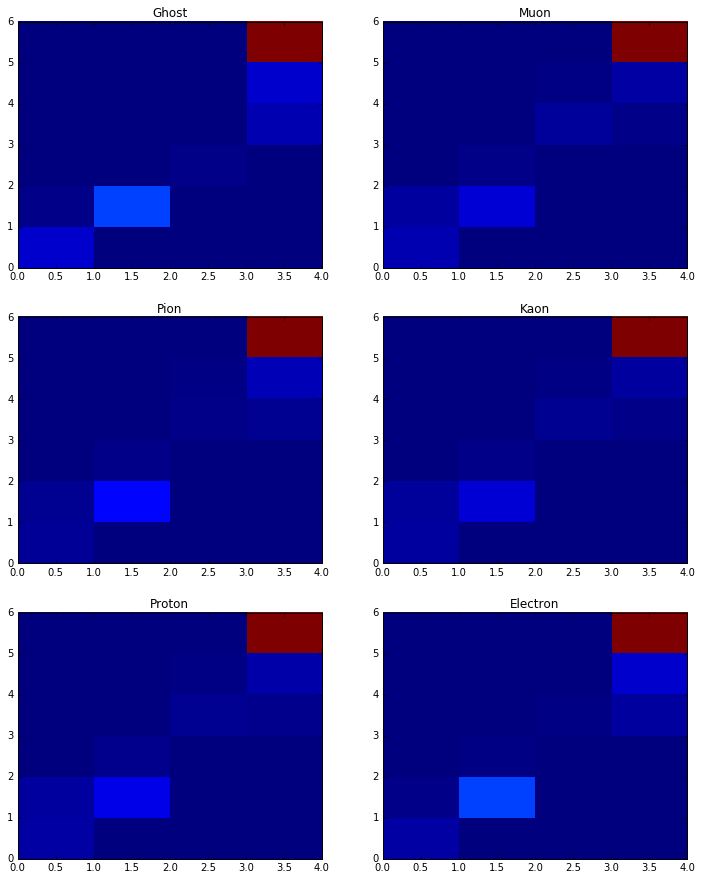

In [28]:
figure(figsize=(12, 15))
for n, (key, val) in enumerate(signal_dict.items()):
    subplot(3, 2, n+1)
    hist2d(acceptance_cum_features.acc_to_right_3[train_data.Signal == val].values, 
           acceptance_cum_features.acc_to_right_5[train_data.Signal == val].values,
           bins=(4, 6), normed=True, cmin=0, cmax=1,)
    title(key)

### use acceptance_to_right_3, acceptance_to_right_5

# CALO features

## PIDe

In [29]:
features_CALO_DLL_e = ['PrsPIDe', 'BremPIDe', 'EcalPIDe', 'HcalPIDe']

In [30]:
correlation = numpy.corrcoef(train_data[features_CALO_DLL_e].values.T)
correlation_test = numpy.corrcoef(test_data[features_CALO_DLL_e].values.T)
print correlation
print correlation - correlation_test

[[ 1.          0.05224835  0.88199905  0.74460798]
 [ 0.05224835  1.          0.10195909  0.02651133]
 [ 0.88199905  0.10195909  1.          0.81365562]
 [ 0.74460798  0.02651133  0.81365562  1.        ]]
[[  0.00000000e+00  -3.16863195e-03   6.09456339e-04   5.65337876e-05]
 [ -3.16863195e-03   0.00000000e+00  -3.32268734e-03  -2.71612669e-03]
 [  6.09456339e-04  -3.32268734e-03   0.00000000e+00   1.78231951e-04]
 [  5.65337876e-05  -2.71612669e-03   1.78231951e-04   0.00000000e+00]]


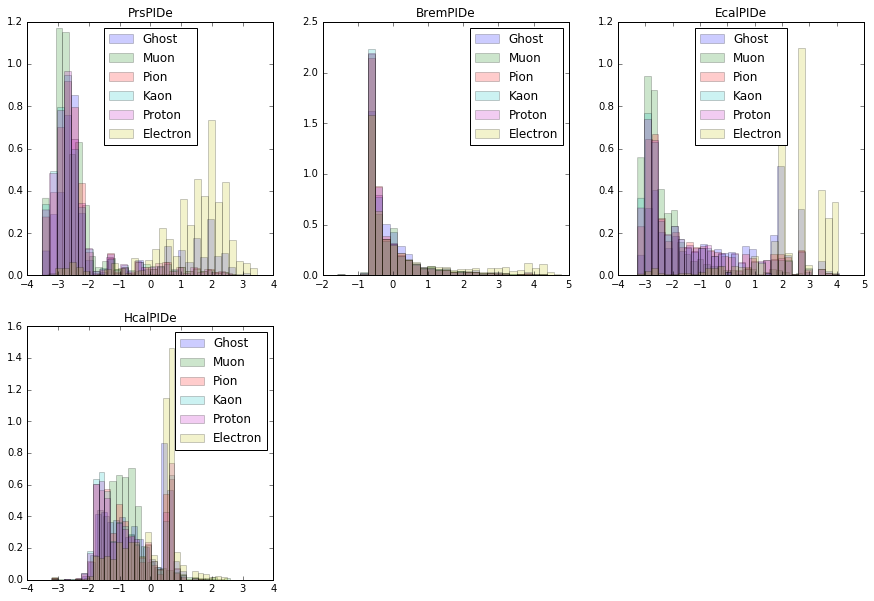

In [31]:
figure(figsize=(15, 10))
hist_features(train_data, train_data.Signal, signal_dict, features_CALO_DLL_e)

In [32]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, train_data[f], signal_dict, train_data.Weight) 
                    for f in features_CALO_DLL_e])
pd.index = features_CALO_DLL_e
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
PrsPIDe,0.514921,0.406889,0.436357,0.425569,0.425303,0.790959
BremPIDe,0.450896,0.523824,0.484893,0.481018,0.488449,0.570921
EcalPIDe,0.539584,0.348290,0.462223,0.444678,0.443578,0.761647
HcalPIDe,0.482777,0.462072,0.474030,0.481829,0.485040,0.614253


In [33]:
roc_auc_score_one_vs_all(train_data.Signal, train_data.PrsPIDe + train_data.EcalPIDe, 
                         signal_dict, train_data.Weight)

(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.536511,0.351964,0.452741,0.437136,0.436389,0.785259


In [34]:
CALO_LL_e_cum_features = compute_cum_sum_features(train_data, features_CALO_DLL_e, 
                                                   'CALO_PID_e_to_right_')

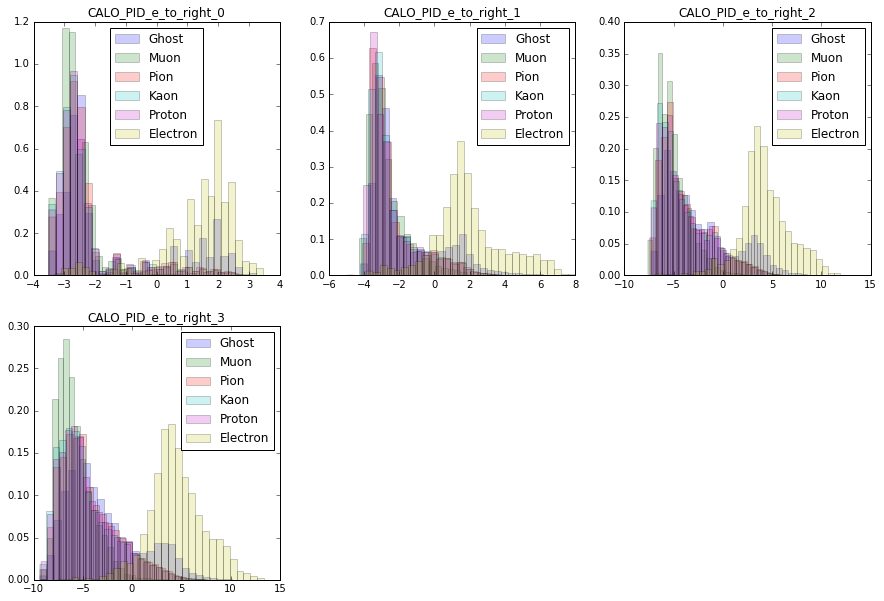

In [35]:
figure(figsize=(15, 10))
hist_features(CALO_LL_e_cum_features, train_data.Signal, signal_dict, CALO_LL_e_cum_features.columns)

In [36]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, CALO_LL_e_cum_features[f], signal_dict, train_data.Weight) 
                    for f in CALO_LL_e_cum_features.columns])
pd.index = CALO_LL_e_cum_features.columns
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
CALO_PID_e_to_right_0,0.514921,0.406889,0.436357,0.425569,0.425303,0.790959
CALO_PID_e_to_right_1,0.422868,0.478479,0.455420,0.468497,0.470236,0.704501
CALO_PID_e_to_right_2,0.437895,0.441110,0.470486,0.479570,0.479683,0.691255
CALO_PID_e_to_right_3,0.435034,0.450658,0.474102,0.489918,0.489456,0.660832


## PIDmu

In [37]:
features_CALO_DLL_mu = ['EcalPIDmu', 'HcalPIDmu']

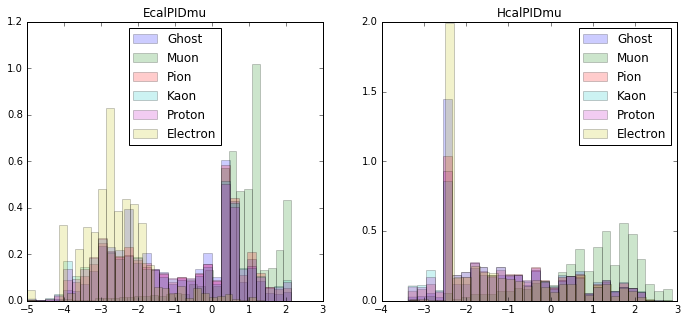

In [38]:
figure(figsize=(18, 5))
hist_features(train_data, train_data.Signal, signal_dict, features_CALO_DLL_mu)

In [39]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, train_data[f], signal_dict, train_data.Weight) 
                    for f in features_CALO_DLL_mu])
pd.index = features_CALO_DLL_mu
pd

(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
EcalPIDmu,0.472002,0.750496,0.505802,0.497419,0.489018,0.285263
HcalPIDmu,0.440791,0.709264,0.478482,0.483662,0.472629,0.415172


In [40]:
roc_auc_score_one_vs_all(train_data.Signal, train_data.EcalPIDmu + train_data.HcalPIDmu, 
                         signal_dict, train_data.Weight)

(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.455514,0.757714,0.496226,0.49542,0.483913,0.311212


### use EcalPIDmu, HcalPIDmu, EcalPIDmu + HcalPIDmu

## energy

In [41]:
features_CALO_E = ['CaloSpdE', 'CaloPrsE', 'CaloEcalE', 'CaloHcalE']

In [42]:
correlation = numpy.corrcoef(train_data[features_CALO_E].values.T)
correlation_test = numpy.corrcoef(test_data[features_CALO_E].values.T)
print correlation
print '------------------------------'
print correlation - correlation_test

[[ 1.          0.97684903  0.31826767  0.21428387]
 [ 0.97684903  1.          0.32709831  0.21357058]
 [ 0.31826767  0.32709831  1.          0.15656498]
 [ 0.21428387  0.21357058  0.15656498  1.        ]]
------------------------------
[[ 0.         -0.00034549  0.01034749  0.0049485 ]
 [-0.00034549  0.          0.00974444  0.0052364 ]
 [ 0.01034749  0.00974444  0.         -0.0165593 ]
 [ 0.0049485   0.0052364  -0.0165593   0.        ]]


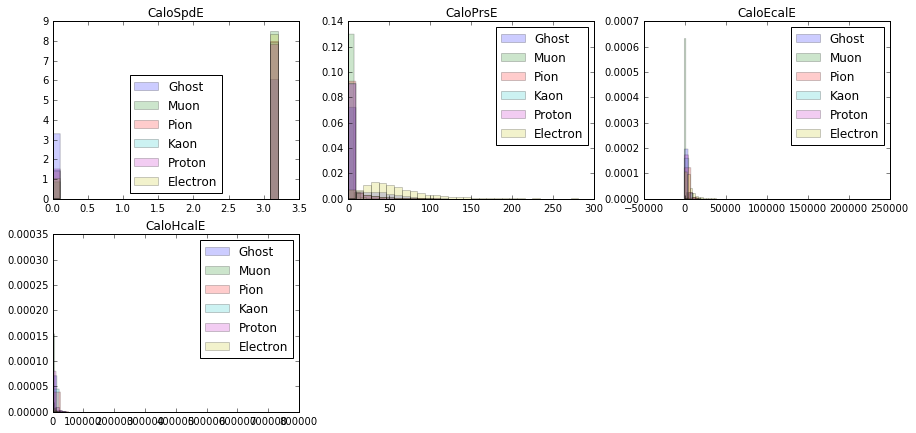

In [43]:
figure(figsize=(15, 7))
hist_features(train_data, train_data.Signal, signal_dict, features_CALO_E)

In [44]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, train_data[f], signal_dict, train_data.Weight) 
                    for f in features_CALO_E])
pd.index = features_CALO_E
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
CaloSpdE,0.397664,0.544977,0.512706,0.525067,0.512241,0.507346
CaloPrsE,0.445811,0.421031,0.443518,0.458224,0.448640,0.782775
CaloEcalE,0.463777,0.306324,0.489631,0.523543,0.512639,0.704086
CaloHcalE,0.435387,0.576376,0.533241,0.572980,0.540859,0.341157


In [45]:
roc_auc_score_one_vs_all(train_data.Signal, train_data.CaloSpdE + train_data.CaloPrsE, 
                         signal_dict, train_data.Weight)

(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.435378,0.428618,0.445471,0.460727,0.450027,0.779778


In [46]:
CALO_E_cum_features = pandas.concat([compute_cum_sum_features(train_data, features_CALO_E, 'CALO_E_to_right_', scale=True),
                                     compute_cum_sum_features(train_data, features_CALO_E[::-1], 'CALO_E_to_left_', scale=True)],
                                    axis=1)

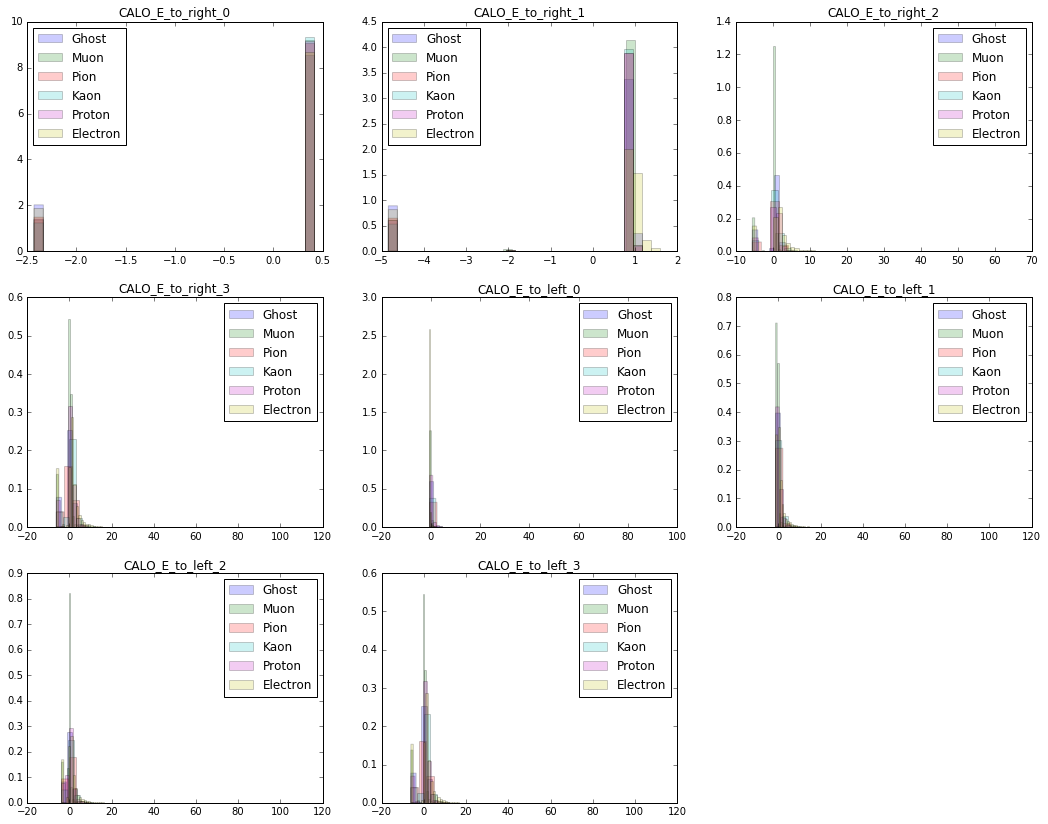

In [47]:
figure(figsize=(18, 14))
hist_features(CALO_E_cum_features, train_data.Signal, signal_dict, CALO_E_cum_features.columns)

In [48]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, CALO_E_cum_features[f], signal_dict, train_data.Weight) 
                    for f in CALO_E_cum_features.columns])
pd.index = CALO_E_cum_features.columns
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
CALO_E_to_right_0,0.397664,0.544977,0.512706,0.525067,0.512241,0.507346
CALO_E_to_right_1,0.435380,0.428619,0.445471,0.460726,0.450026,0.779779
CALO_E_to_right_2,0.453626,0.311344,0.487526,0.521771,0.510817,0.714917
CALO_E_to_right_3,0.431815,0.332936,0.503278,0.558862,0.531884,0.641226
CALO_E_to_left_0,0.435387,0.576376,0.533241,0.572980,0.540859,0.341157
CALO_E_to_left_1,0.431521,0.337320,0.507801,0.562288,0.534884,0.626186
CALO_E_to_left_2,0.432380,0.332169,0.503250,0.558850,0.531778,0.641573
CALO_E_to_left_3,0.431815,0.332936,0.503278,0.558862,0.531884,0.641226


### use energy separate, HcalPIDmu, CaloSpdE + CaloPrsE

## Neutral

In [49]:
features_CALO_neutral = ['CaloNeutralSpd', 'CaloNeutralPrs', 'CaloNeutralEcal']

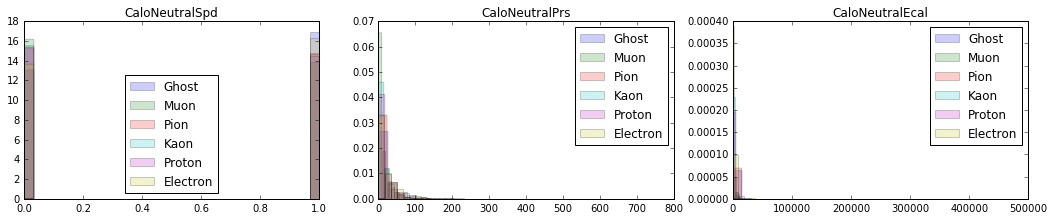

In [50]:
figure(figsize=(18, 7))
hist_features(train_data, train_data.Signal.values, signal_dict, features_CALO_neutral)

In [51]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, train_data[f], signal_dict, train_data.Weight) 
                    for f in features_CALO_neutral])
pd.index = features_CALO_neutral
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
CaloNeutralSpd,0.443627,0.519298,0.502304,0.506171,0.510831,0.517769
CaloNeutralPrs,0.459808,0.500102,0.494134,0.491699,0.494152,0.560105
CaloNeutralEcal,0.480804,0.486479,0.495103,0.484908,0.487083,0.565623


In [52]:
roc_auc_score_one_vs_all(train_data.Signal, train_data.CaloNeutralSpd + train_data.InAccSpd, 
                         signal_dict, train_data.Weight)

(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.424855,0.532048,0.502376,0.518416,0.51891,0.503395


### Use CaloNeutralSpd + InAccSpd for Ghost

## Charged

In [53]:
features_CALO_charged = ['CaloChargedSpd', 'CaloChargedPrs' , 'CaloChargedEcal']

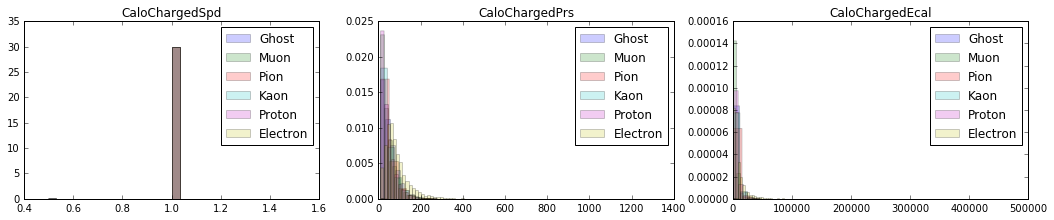

In [54]:
figure(figsize=(18, 7))
hist_features(train_data, train_data.Signal, signal_dict, features_CALO_charged)

In [55]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, train_data[f], signal_dict, train_data.Weight) 
                    for f in features_CALO_charged])
pd.index = features_CALO_charged
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
CaloChargedSpd,0.529469,0.382628,0.516415,0.505143,0.506772,0.559573
CaloChargedPrs,0.531155,0.354973,0.477930,0.472191,0.472323,0.691429
CaloChargedEcal,0.518085,0.344432,0.483069,0.491658,0.489551,0.673204


In [56]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, 
                                             train_data.CaloChargedSpd + train_data.CaloNeutralSpd + train_data.InAccSpd, 
                                             signal_dict, train_data.Weight),
                    roc_auc_score_one_vs_all(train_data.Signal, 
                                             train_data.CaloChargedSpd + train_data.CaloNeutralSpd, 
                                             signal_dict, train_data.Weight),
                    roc_auc_score_one_vs_all(train_data.Signal, 
                                             train_data.CaloChargedSpd + train_data.InAccSpd, 
                                             signal_dict, train_data.Weight),
                    roc_auc_score_one_vs_all(train_data.Signal, 
                                             train_data.CaloNeutralSpd + train_data.InAccSpd, 
                                             signal_dict, train_data.Weight)])
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.474357,0.423535,0.513555,0.516231,0.519990,0.552333
0,0.479553,0.412800,0.514602,0.512719,0.518735,0.561592
0,0.516956,0.403496,0.515322,0.510126,0.508687,0.545413
0,0.424855,0.532048,0.502376,0.518416,0.518910,0.503395


### use CaloNeutralSpd + InAccSpd for Ghost
### use CaloChargedSpd + InAccSpd for Muon
### use CaloNeutralSpd + CaloChargedSpd for Electron

## Others

In [57]:
features_CALO_others = ['CaloBremMatch', 'CaloElectronMatch', 'CaloTrMatch', 'CaloTrajectoryL']

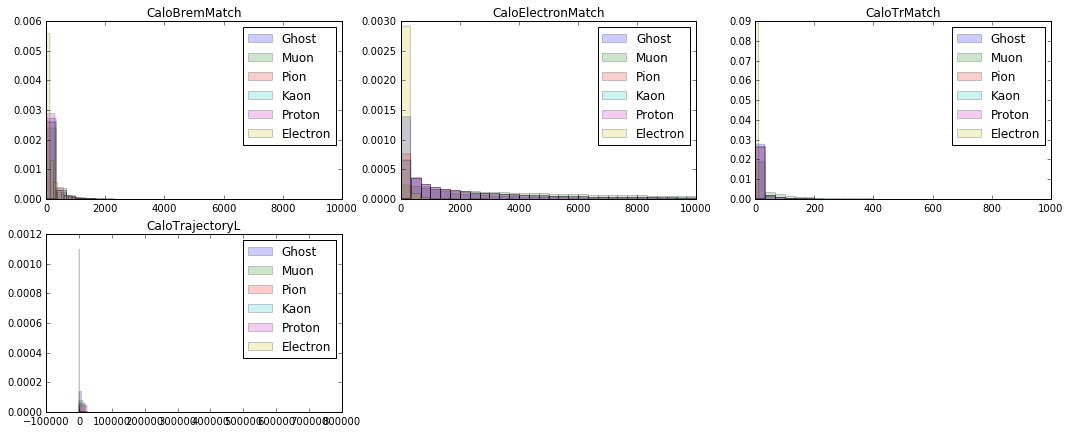

In [58]:
figure(figsize=(18, 7))
hist_features(train_data, train_data.Signal, signal_dict, features_CALO_others)

In [59]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, train_data[f], signal_dict, train_data.Weight) 
                    for f in features_CALO_others])
pd.index = features_CALO_others
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
CaloBremMatch,0.404058,0.582076,0.511669,0.519162,0.518326,0.464709
CaloElectronMatch,0.495381,0.475092,0.562488,0.566655,0.566001,0.334383
CaloTrMatch,0.486180,0.670706,0.534847,0.526450,0.511600,0.270216
CaloTrajectoryL,0.538468,0.377747,0.507141,0.494265,0.491906,0.590472


# RICH features

## DLL

In [60]:
features_RICH_DLL = filter(lambda x: 'RichDLL' in x, train_data.columns)

In [61]:
features_RICH_DLL

['RichDLLbt', 'RichDLLpi', 'RichDLLe', 'RichDLLp', 'RichDLLmu', 'RichDLLk']

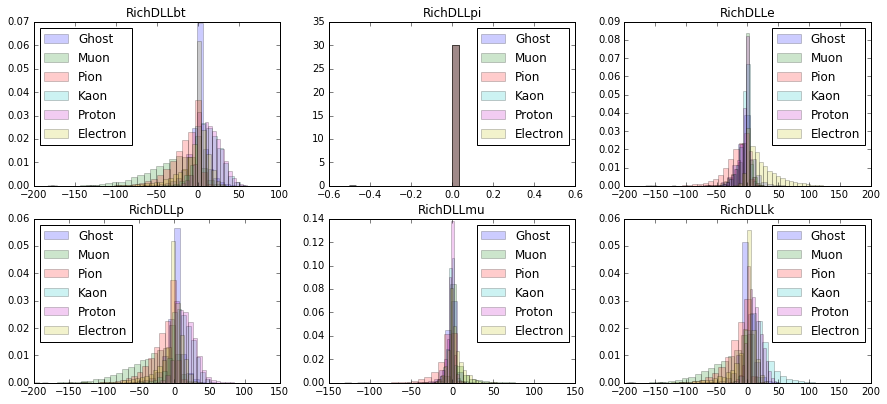

In [62]:
figure(figsize=(15, 10))
hist_features(train_data, train_data.Signal, signal_dict, features_RICH_DLL)

In [63]:
RICH_LL_features = convert_DLL_to_LL(train_data, list(set(features_RICH_DLL) - {'RichDLLbt'}))

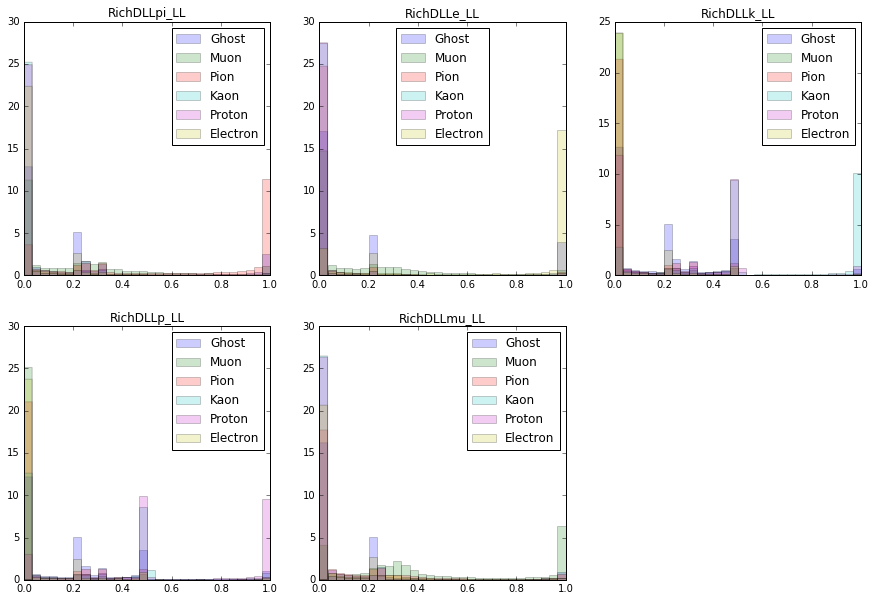

In [64]:
figure(figsize=(15, 10))
hist_features(RICH_LL_features, train_data.Signal, signal_dict, RICH_LL_features.columns)

In [65]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, train_data[f], signal_dict, train_data.Weight) 
                    for f in features_RICH_DLL])
pd.index = features_RICH_DLL
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
RichDLLbt,0.440354,0.231854,0.292772,0.767021,0.804564,0.463435
RichDLLpi,0.437791,0.521122,0.515073,0.521581,0.521233,0.483200
RichDLLe,0.422790,0.527058,0.238686,0.485774,0.489439,0.836252
RichDLLp,0.439307,0.226789,0.292634,0.755184,0.824912,0.461174
RichDLLmu,0.416904,0.708245,0.299875,0.466210,0.476405,0.632360
RichDLLk,0.429343,0.242421,0.277072,0.842118,0.757699,0.451346


In [66]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, RICH_LL_features[f], signal_dict, train_data.Weight) 
                    for f in RICH_LL_features.columns])
pd.index = RICH_LL_features.columns
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
RichDLLpi_LL,0.586616,0.615908,0.863323,0.290970,0.299776,0.343407
RichDLLe_LL,0.555223,0.580760,0.370474,0.294072,0.293855,0.905617
RichDLLk_LL,0.542423,0.296202,0.364682,0.880377,0.621913,0.294403
RichDLLp_LL,0.558530,0.276821,0.378889,0.605589,0.873260,0.306911
RichDLLmu_LL,0.564974,0.859520,0.541393,0.294993,0.300623,0.438497


### Use DLL and LL

## Gas

In [67]:
features_RICH_gas = ['RichUsedR1Gas', 'RichUsedR2Gas']

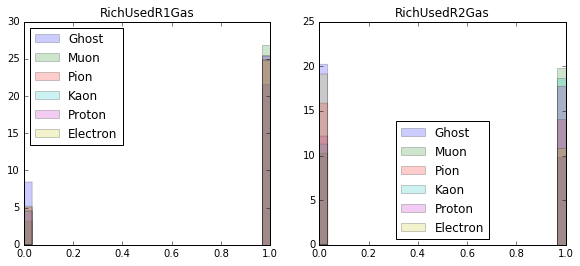

In [68]:
figure(figsize=(15, 4))
hist_features(train_data, train_data.Signal, signal_dict, features_RICH_gas)

In [69]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, train_data[f], signal_dict, train_data.Weight) 
                    for f in features_RICH_gas])
pd.index = features_RICH_gas
pd

(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
RichUsedR1Gas,0.434030,0.539634,0.502702,0.510732,0.513478,0.499424
RichUsedR2Gas,0.392099,0.591451,0.479156,0.570656,0.552808,0.413830


In [70]:
roc_auc_score_one_vs_all(train_data.Signal, train_data.RichUsedR1Gas + train_data.RichUsedR2Gas,
                         signal_dict, train_data.Weight)

(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.355774,0.617359,0.477736,0.570034,0.555815,0.423281


### use RichUsedR1Gas, RichUsedR2Gas, RichUsedR1Gas + RichUsedR2Gas

## Above

In [71]:
features_RICH_above = filter(lambda x: 'RichAbove' in x, train_data.columns)

In [72]:
print features_RICH_above

['RichAboveMuThres', 'RichAboveElThres', 'RichAbovePiThres', 'RichAboveKaThres', 'RichAbovePrThres']


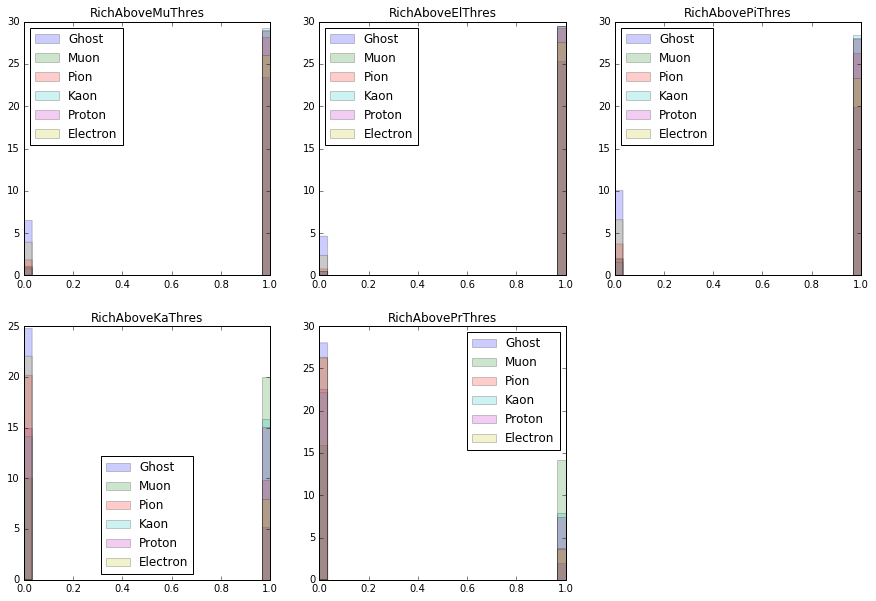

In [73]:
figure(figsize=(15, 10))
hist_features(train_data, train_data.Signal, signal_dict, features_RICH_above)

In [74]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, train_data[f], signal_dict, train_data.Weight) 
                    for f in features_RICH_above])
pd.index = features_RICH_above
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
RichAboveMuThres,0.420258,0.528886,0.513441,0.534716,0.530986,0.471712
RichAboveElThres,0.437791,0.521122,0.515073,0.521581,0.521233,0.483200
RichAbovePiThres,0.385151,0.546268,0.511651,0.555340,0.547334,0.454256
RichAboveKaThres,0.358035,0.653033,0.450291,0.571093,0.555028,0.412519
RichAbovePrThres,0.409652,0.652769,0.445806,0.527520,0.520036,0.444217


In [75]:
roc_auc_score_one_vs_all(train_data.Signal, train_data.RichAboveKaThres + train_data.RichAbovePrThres + \
                         train_data.RichAboveElThres + train_data.RichAbovePiThres,
                         signal_dict, train_data.Weight)

(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.301214,0.688757,0.454306,0.589717,0.571994,0.394012


In [76]:
roc_auc_score_one_vs_all(train_data.Signal, train_data.RichAbovePiThres + train_data.RichAboveKaThres + \
                         train_data.RichAboveElThres + train_data.RichAboveMuThres,
                         signal_dict, train_data.Weight)

(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.3078,0.6589,0.465809,0.593866,0.575688,0.397937


In [77]:
roc_auc_score_one_vs_all(train_data.Signal, train_data.RichAboveKaThres + train_data.RichAbovePrThres,
                         signal_dict, train_data.Weight)

(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
0,0.351568,0.682777,0.43875,0.567043,0.551374,0.408488


### Use Above, Pion + Kaon + Electron + Muon, Kaon + Proton

# Comb DLL

In [78]:
features_Comb_DLL = filter(lambda x: 'CombDLL' in x, train_data.columns)

In [79]:
features_Comb_DLL

['CombDLLmu', 'CombDLLpi', 'CombDLLp', 'CombDLLe', 'CombDLLk']

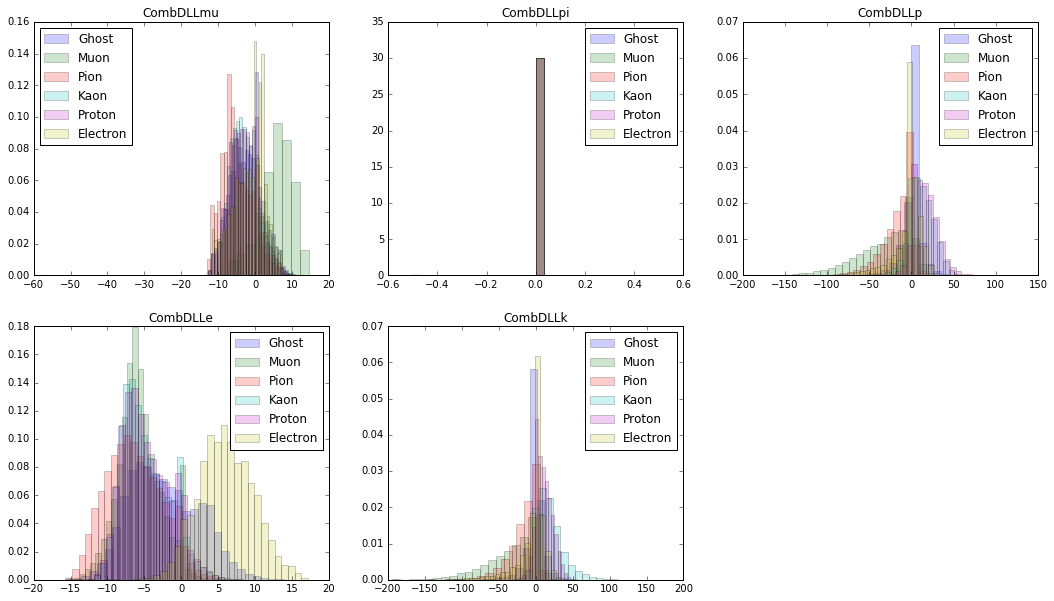

In [80]:
figure(figsize=(18, 10))
hist_features(train_data, train_data.Signal, signal_dict, features_Comb_DLL)

In [81]:
comb_LL_features = convert_DLL_to_LL(train_data, features_Comb_DLL)

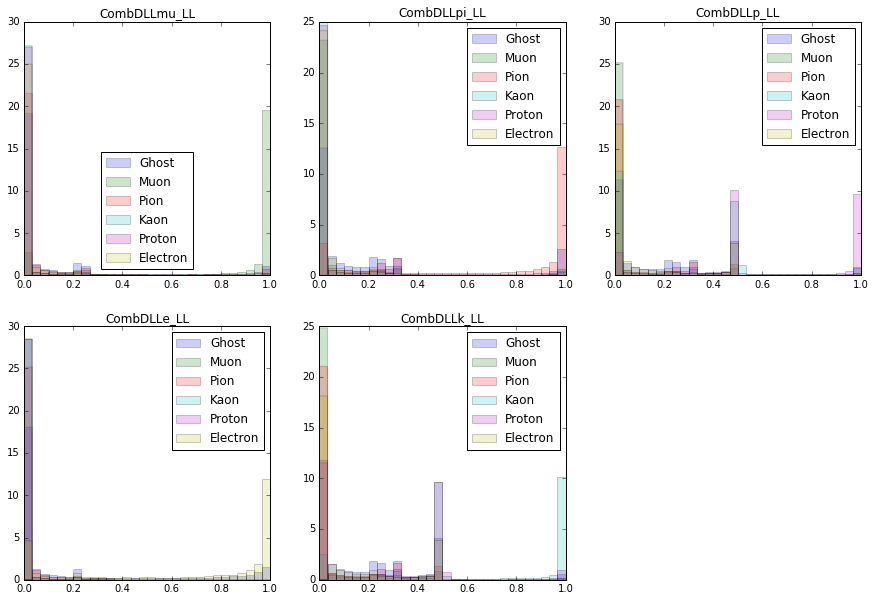

In [82]:
figure(figsize=(15, 10))
hist_features(comb_LL_features, train_data.Signal, signal_dict, comb_LL_features.columns)

In [83]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, train_data[f], signal_dict, train_data.Weight) 
                    for f in features_Comb_DLL])
pd.index = features_Comb_DLL
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
CombDLLmu,0.453679,0.905947,0.289779,0.407793,0.415740,0.527062
CombDLLpi,0.488817,0.501956,0.504231,0.503163,0.502478,0.499356
CombDLLp,0.489271,0.192021,0.267174,0.750723,0.823973,0.476838
CombDLLe,0.557479,0.353900,0.299126,0.407963,0.422164,0.959368
CombDLLk,0.477898,0.208372,0.251152,0.842034,0.754538,0.466006


In [84]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, comb_LL_features[f], signal_dict, train_data.Weight) 
                    for f in comb_LL_features.columns])
pd.index = comb_LL_features.columns
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
CombDLLmu_LL,0.559292,0.942968,0.557201,0.255956,0.262250,0.422333
CombDLLpi_LL,0.650983,0.473661,0.900822,0.266231,0.276419,0.431884
CombDLLp_LL,0.556069,0.229774,0.335425,0.578208,0.866445,0.434079
CombDLLe_LL,0.639025,0.327768,0.528669,0.292263,0.297250,0.915025
CombDLLk_LL,0.542155,0.236954,0.322942,0.875452,0.597295,0.425202


# LL combination

In [85]:
RICH_LL_features.columns

Index([u'RichDLLpi_LL', u'RichDLLe_LL', u'RichDLLk_LL', u'RichDLLp_LL',
       u'RichDLLmu_LL'],
      dtype='object')

In [86]:
temp = OrderedDict()
for f in ['mu', 'pi', 'p', 'k', 'e']:
    temp[f] = comb_LL_features['CombDLL{}_LL'.format(f)].values * RICH_LL_features['RichDLL{}_LL'.format(f)].values
temp = pandas.DataFrame(temp)

In [87]:
LL_features = pandas.DataFrame(temp.values / temp.values.sum(axis=1, keepdims=True), columns=temp.columns)

In [88]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, LL_features[f], signal_dict, train_data.Weight) 
                    for f in LL_features.columns])
pd.index = LL_features.columns
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
mu,0.537996,0.916829,0.492076,0.325332,0.328968,0.398799
pi,0.607365,0.514525,0.881718,0.317793,0.324942,0.353657
p,0.552762,0.287147,0.373987,0.591127,0.865117,0.329860
k,0.539621,0.297065,0.363972,0.873928,0.605690,0.319724
e,0.579002,0.399669,0.404428,0.340152,0.339209,0.937541


### Use CombDLL + CombLL

## Track features

In [89]:
features_track = filter(lambda x: 'Track' in x, train_data.columns)

In [90]:
print features_track

['TrackMatchChi2', 'TrackGhostProbability', 'TrackType', 'TrackPt', 'TrackP', 'TrackChi2PerDof', 'TrackNumDof', 'NumUpstreamTracks', 'NumLongTracks', 'NumDownstreamTracks', 'NumMuonTracks', 'NumVeloTracks', 'NumTTracks', 'TrackFitMatchChi2', 'TrackHistory', 'TrackCloneDist', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'TrackFitTNDoF', 'TrackDOCA', 'TrackLikelihood', 'TrackFitVeloChi2']


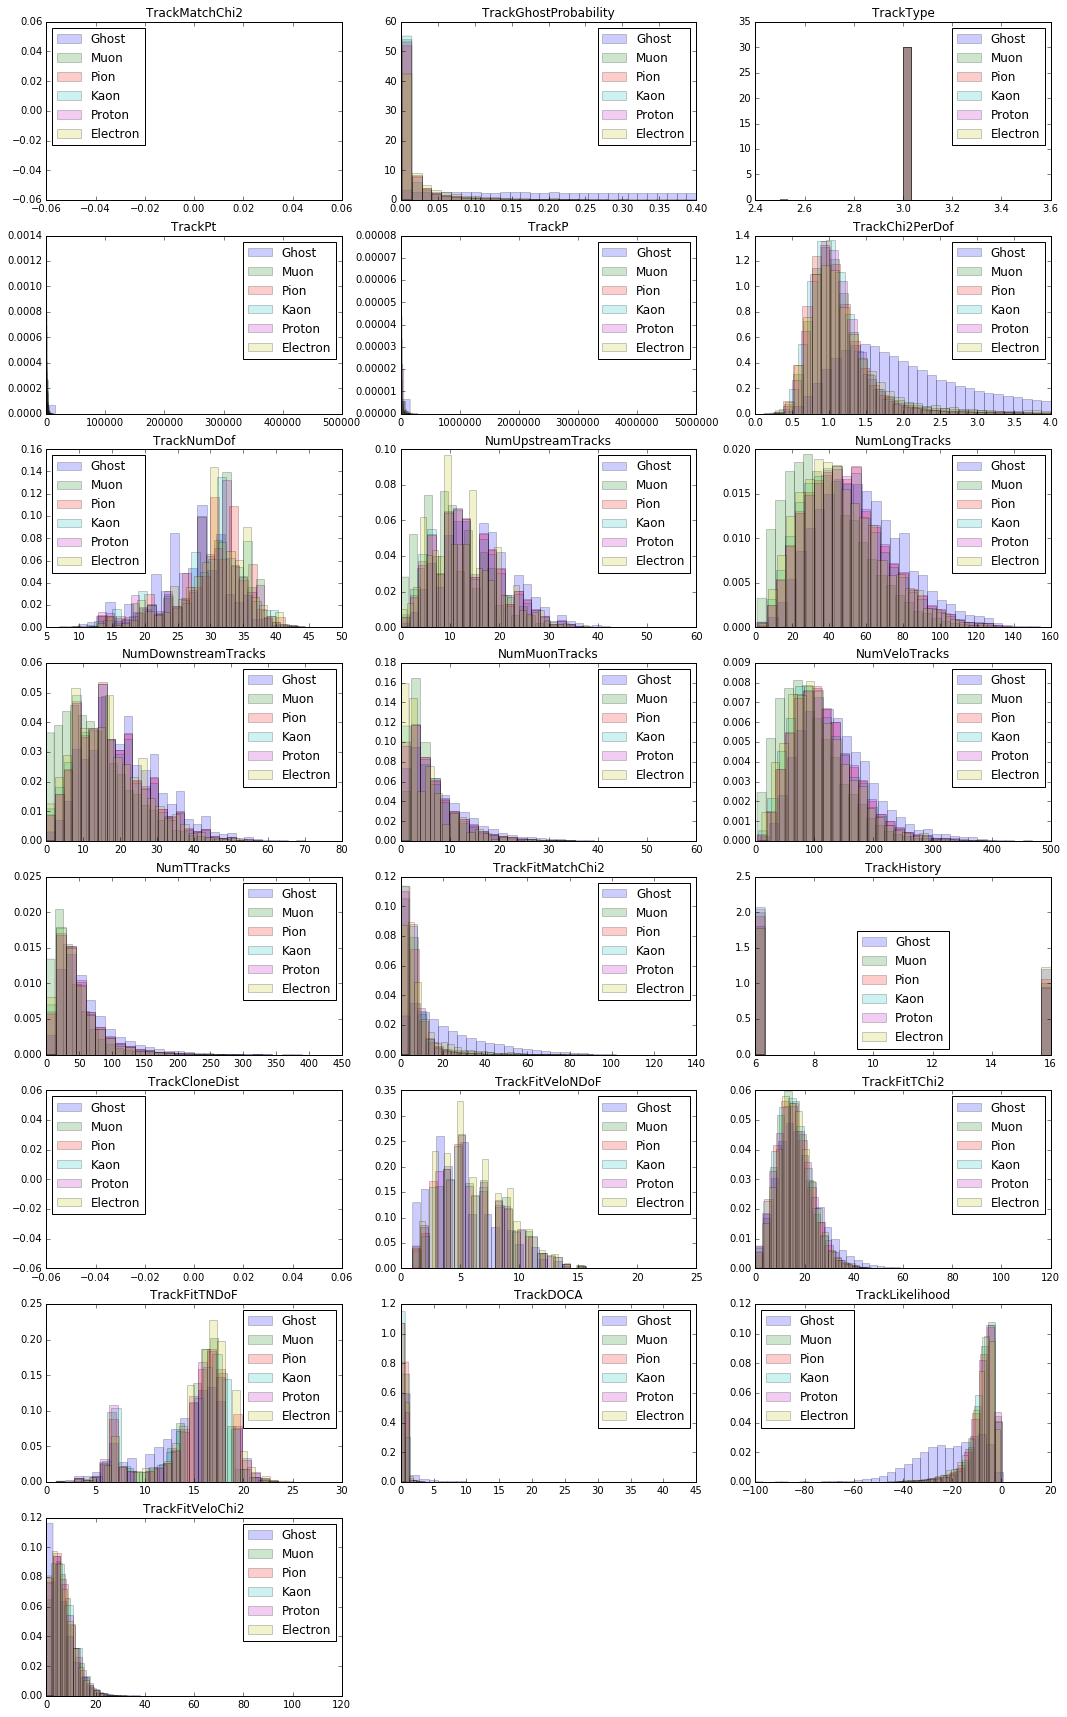

In [91]:
figure(figsize=(18, 30))
hist_features(train_data, train_data.Signal, signal_dict, features_track)

In [92]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, train_data[f], signal_dict, train_data.Weight) 
                    for f in features_track])
pd.index = features_track
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
TrackMatchChi2,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
TrackGhostProbability,0.930090,0.380796,0.411444,0.376401,0.399939,0.501331
TrackType,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
TrackPt,0.214661,0.774840,0.432156,0.601209,0.598282,0.378851
TrackP,0.310992,0.693748,0.446735,0.595359,0.572553,0.380614
TrackChi2PerDof,0.825811,0.450306,0.406479,0.413987,0.438287,0.465130
TrackNumDof,0.336884,0.533465,0.535516,0.524300,0.508678,0.561157
NumUpstreamTracks,0.621463,0.371659,0.516143,0.495415,0.521850,0.473470
NumLongTracks,0.636297,0.350900,0.518925,0.496424,0.524171,0.473284
NumDownstreamTracks,0.630632,0.365573,0.513176,0.492872,0.516873,0.480874


In [93]:
features_track = list(set(features_track) - {'TrackMatchChi2', 'TrackType', 'TrackCloneDist', 'TrackLikelihood'})

# Muon features

## ???? 'InAccMuon', 'NumMuonTracks'

In [94]:
features_muon = ['MuonNShared', 'MuonIsLooseMuon', 'MuonIsMuon', 'MuonBkgLL', 'MuonMuLL'] 

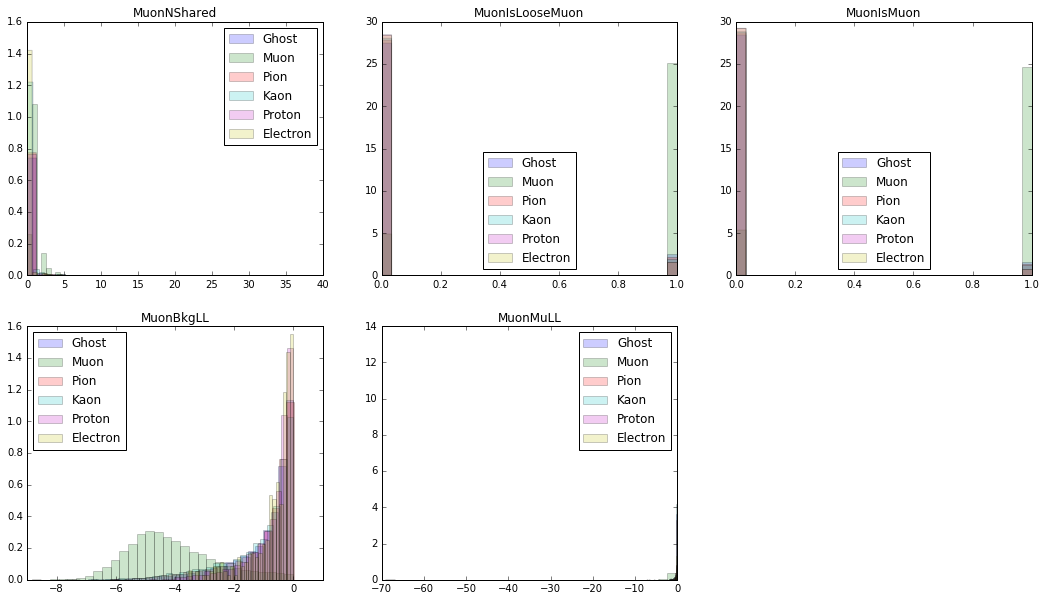

In [95]:
figure(figsize=(18, 10))
hist_features(train_data, train_data.Signal, signal_dict, features_muon)

In [96]:
pd = pandas.concat([roc_auc_score_one_vs_all(train_data.Signal, train_data[f], signal_dict, train_data.Weight) 
                    for f in features_muon])
pd.index = features_muon
pd

(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)
(1200000, 6)


,Ghost,Muon,Pion,Kaon,Proton,Electron
MuonNShared,0.438842,0.871729,0.429698,0.424479,0.416549,0.418703
MuonIsLooseMuon,0.434219,0.885712,0.426937,0.422669,0.414532,0.415931
MuonIsMuon,0.430390,0.891745,0.425377,0.422804,0.414634,0.415051
MuonBkgLL,0.440158,0.861136,0.432034,0.427072,0.418659,0.420316
MuonMuLL,0.439410,0.864870,0.431101,0.426576,0.418121,0.419798


# Symmetry

In [97]:
1. * sum(train_data.Charge == 1) / len(train_data), 1. * sum(train_data.Charge == -1) / len(train_data),

(0.4336758333333333, 0.4245583333333333)

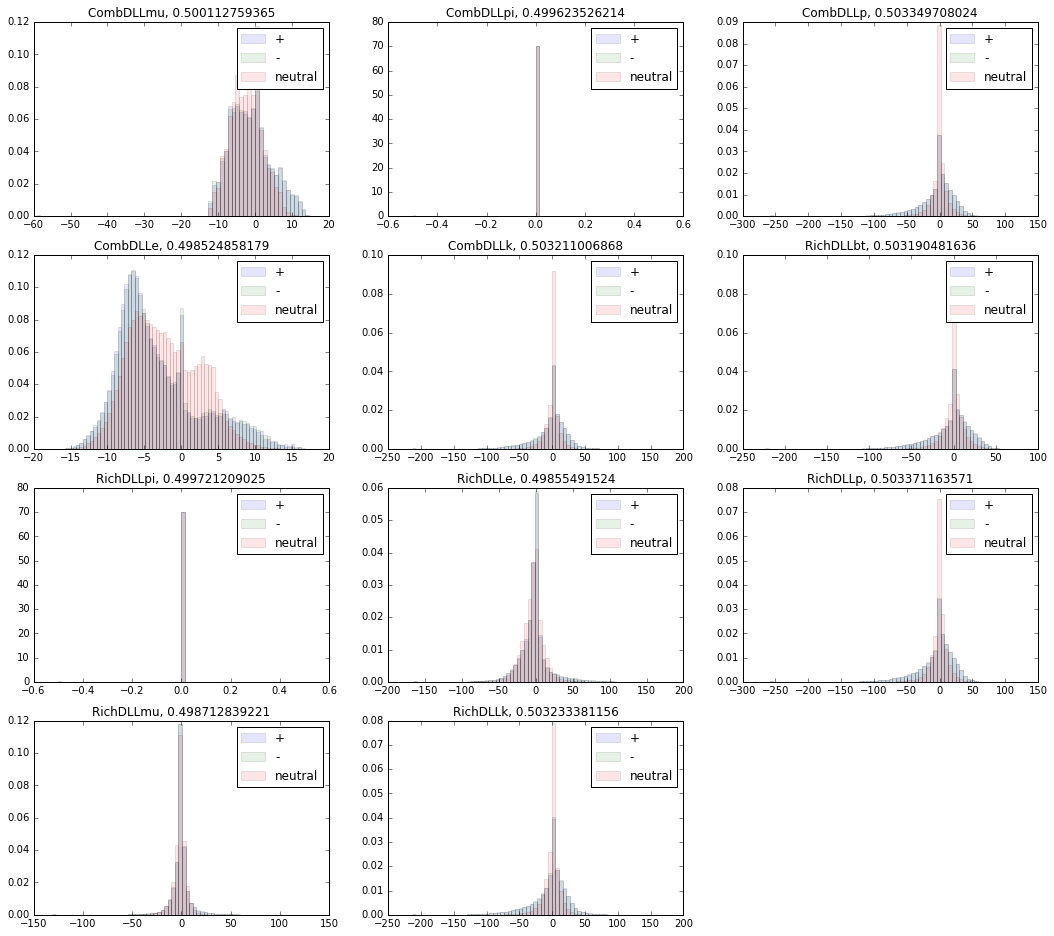

In [98]:
figure(figsize=(18, 16))
for n, f in enumerate(features_Comb_DLL + features_RICH_DLL):
    subplot(4, 3, n+1)
    mask = train_data[f] > -400
    limit = min(train_data[f][mask]), max(train_data[f][mask])
    params = {'bins': 70, 'alpha': 0.1, 'range': limit, 'normed': True}
    hist(train_data.loc[(train_data.Charge == 1) & mask, f].values, label = '+', 
         weights=train_data.loc[(train_data.Charge == 1) & mask, 'Weight'], **params)
    hist(train_data.loc[(train_data.Charge == -1) & mask, f].values, label = '-', 
         weights=train_data.loc[(train_data.Charge == -1) & mask, 'Weight'], **params)
    hist(train_data.loc[(train_data.Charge == 0) & mask, f].values, label = 'neutral', 
         weights=train_data.loc[(train_data.Charge == 0) & mask, 'Weight'], **params)
    mask = train_data.Charge.values != 0
    title('{}, {}'.format(f, roc_auc_score(train_data.loc[mask, 'Charge'], train_data.loc[mask, f])))
    legend()

# DLL flatness

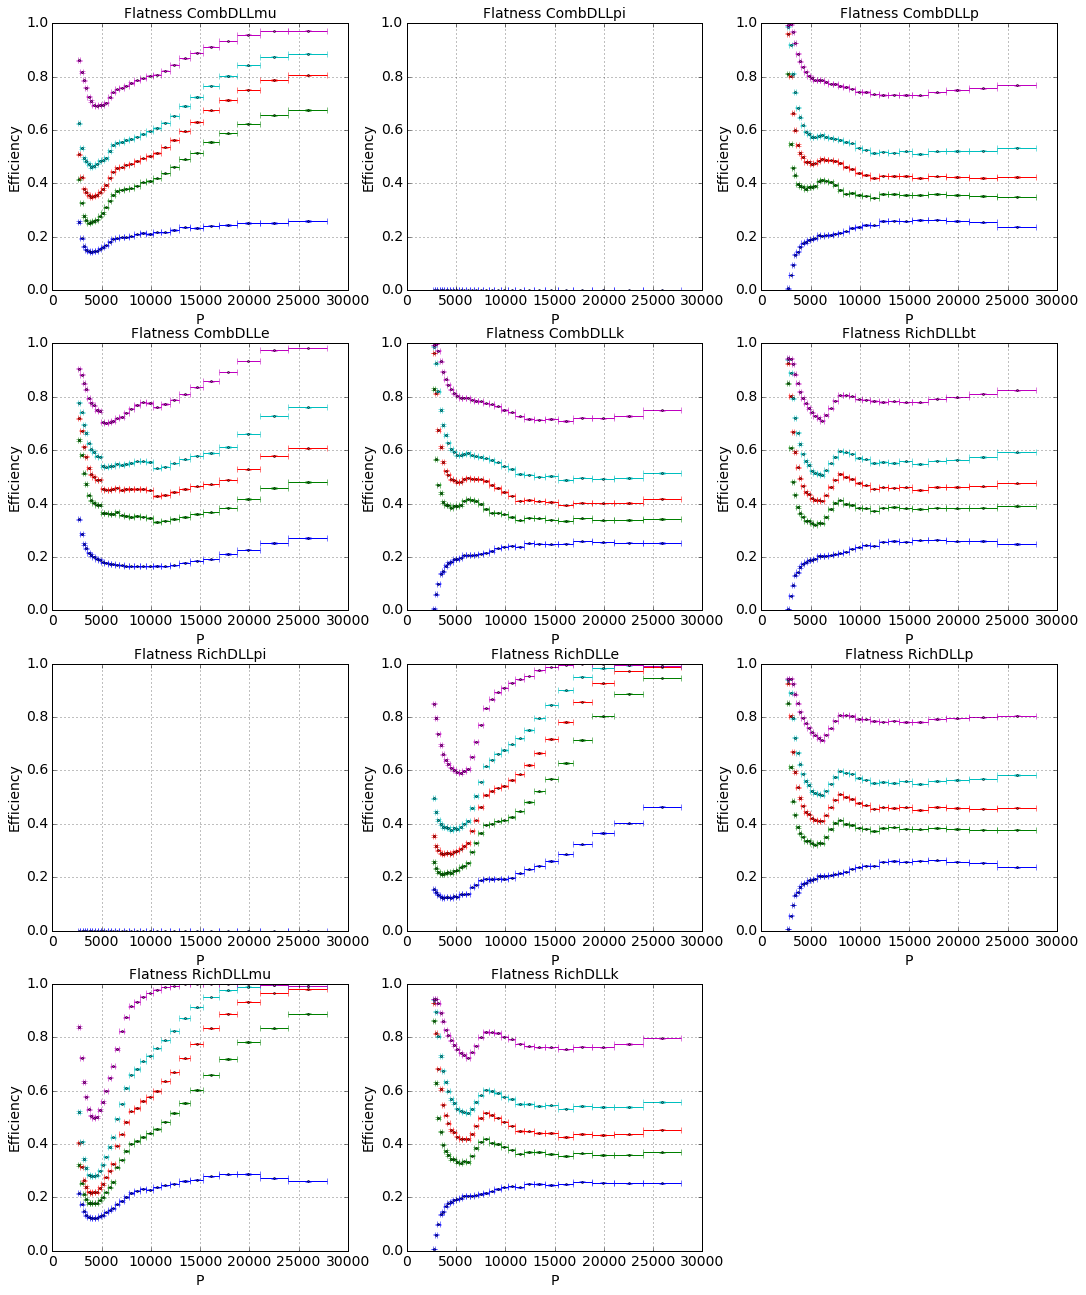

In [99]:
from rep.utils import get_efficiencies
from rep.plotting import ErrorPlot

figure(figsize=(18, 22))
for n, f in enumerate(features_Comb_DLL + features_RICH_DLL):
    subplot(4, 3, n+1)
    eff = get_efficiencies(train_data[f], train_data.TrackP, bins_number=30, errors=True, ignored_sideband=0.1)
    plot_fig = ErrorPlot(eff)
    plot_fig.xlabel = 'P'
    plot_fig.ylabel = 'Efficiency'
    plot_fig.title = 'Flatness ' + f
    plot_fig.ylim = (0, 1)
    plot_fig.plot(show_legend=False)

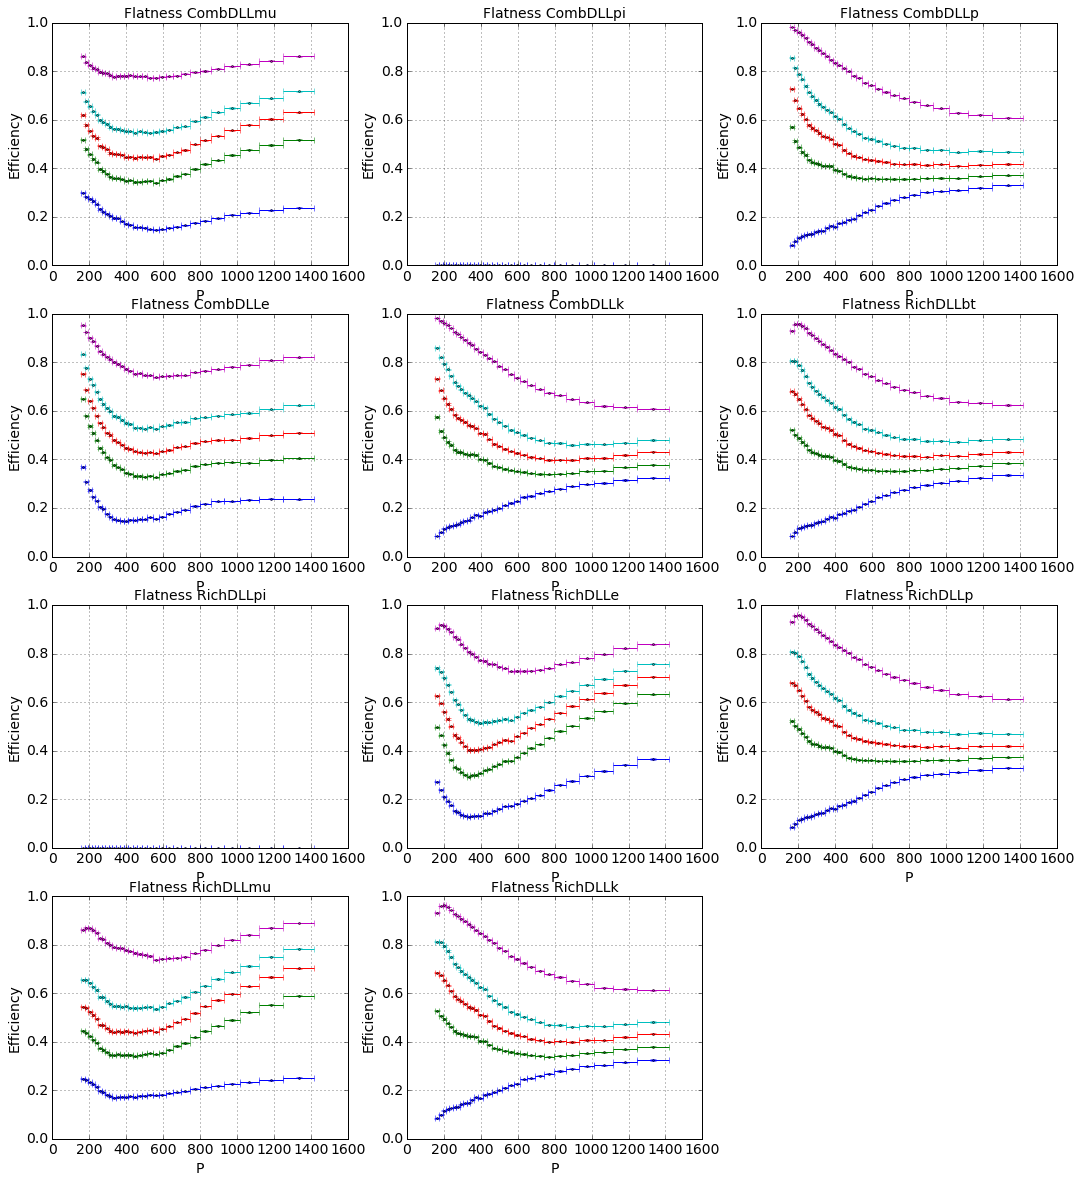

In [100]:
figure(figsize=(18, 20))
for n, f in enumerate(features_Comb_DLL + features_RICH_DLL):
    subplot(4, 3, n+1)
    eff = get_efficiencies(train_data[f], train_data.TrackPt, bins_number=30, errors=True, ignored_sideband=0.1)
    plot_fig = ErrorPlot(eff)
    plot_fig.xlabel = 'P'
    plot_fig.ylabel = 'Efficiency'
    plot_fig.title = 'Flatness ' + f
    plot_fig.ylim = (0, 1)
    plot_fig.plot(show_legend=False)

# Define features; prepare data;

In [101]:
features_base = features_acceptance + \
    features_CALO_DLL_e + features_CALO_DLL_mu + features_CALO_E + \
    features_CALO_charged + features_CALO_neutral + features_CALO_others + \
    features_RICH_gas + features_RICH_DLL + features_RICH_above + \
    features_Comb_DLL + features_track + features_muon

In [102]:
def add_features(data):
    added_features = []
    data_comb = numpy.log(convert_DLL_to_LL(data, features_Comb_DLL))
    data_rich = numpy.log(convert_DLL_to_LL(data, list(set(features_RICH_DLL) - {'RichDLLbt'})))
    data_acceptance = compute_cum_sum_features(data, features_acceptance, name='acc_cum_sum_')
    added_features = list(data_comb.columns) + list(data_rich.columns) + ['acc_cum_sum_3', 'acc_cum_sum_5']
    
    new_data = pandas.concat([data, data_rich, data_comb, data_acceptance[added_features[-2:]]], axis=1)
    
    new_data['RichAboveSumPiKaElMuTHres'] = new_data.RichAbovePiThres + new_data.RichAboveKaThres + \
        new_data.RichAboveElThres + new_data.RichAboveMuThres
    new_data['RichAboveSumKaPrTHres'] = new_data.RichAboveKaThres + new_data.RichAbovePrThres
    new_data['RichUsedGas'] = new_data.RichUsedR1Gas + new_data.RichUsedR2Gas
    new_data['SpdCaloNeutralAcc'] = new_data.CaloNeutralSpd + new_data.InAccSpd # for ghost
    new_data['SpdCaloChargedAcc'] = new_data.CaloChargedSpd + new_data.InAccSpd # for muon
    new_data['SpdCaloChargedNeutral'] = new_data.CaloChargedSpd + new_data.CaloNeutralSpd # for electron
    new_data['CaloSumSpdPrsE'] = new_data.CaloSpdE + new_data.CaloPrsE 
    new_data['CaloSumPIDmu'] = new_data.EcalPIDmu + new_data.HcalPIDmu 
    added_features = added_features + ['RichAboveSumPiKaElMuTHres', 'RichAboveSumKaPrTHres', 'RichUsedGas', 
                                       'SpdCaloNeutralAcc', 'SpdCaloChargedAcc', 'SpdCaloChargedNeutral', 
                                       'CaloSumSpdPrsE', 'CaloSumPIDmu']
    return new_data, added_features

In [103]:
train_data_extended, features_extended = add_features(train_data)
test_data_extended, _ = add_features(test_data)

# NN training

In [104]:
from hep_ml.nnet import MLPMultiClassifier
from rep.estimators import SklearnClassifier

In [105]:
values, indices, labels = numpy.unique(train_data.Signal, return_index=True, return_inverse=True)

In [106]:
values

array([   0,   11,   13,  211,  321, 2212])

In [124]:
labels_corrrespondence = OrderedDict()
for val in values:
    labels_corrrespondence[signal_dict_inverse[val]] = val

In [107]:
labels[indices]

array([0, 1, 2, 3, 4, 5])

In [108]:
len(features_base)

67

In [109]:
rocs_baseline = pandas.read_csv("../python/class_vs_class_roc_auc_matrix_baseline.csv", index_col=0)

In [110]:
rocs_baseline

,Electron,Proton,Pion,Muon,Kaon,Ghost
Electron,1.000000,0.985355,0.977771,0.996391,0.984852,0.953768
Proton,0.985350,1.000000,0.954159,0.994473,0.787170,0.974741
Pion,0.977451,0.954160,1.000000,0.987573,0.954936,0.960650
Muon,0.996388,0.994473,0.987599,1.000000,0.993378,0.992028
Kaon,0.984885,0.787170,0.954936,0.993378,1.000000,0.977237
Ghost,0.953768,0.974741,0.960650,0.992028,0.977237,1.000000


## Base features; multiclass

In [113]:
%%time 
nn_base = SklearnClassifier(MLPMultiClassifier(layers=(30, 10), scaler='iron', 
                                               random_state=11, epochs=700), features=features_base)
nn_base.fit(train_data, labels, train_data.Weight)

CPU times: user 31min 11s, sys: 12min 9s, total: 43min 20s
Wall time: 27min 23s


In [114]:
pred = nn_base.predict_proba(test_data)
pred_dict = OrderedDict()
for n, v in enumerate(values):
    pred_dict[signal_dict_inverse[v]] = pred[:, n]

In [115]:
from collections import defaultdict
def roc_auc_score_one_vs_one(labels, pred, signal_dict):
    rocs = OrderedDict()
    keys = ["Electron", "Proton", "Pion", "Muon", "Kaon", "Ghost"]
    for key in keys:
        rocs[key] = []
        for key_ in keys:
            if key == key_:
                rocs[key].append(1.)
            else:
                label = signal_dict[key]
                label_ = signal_dict[key_]
                mask = (labels == label) | (labels == label_)
                rocs[key].append(roc_auc_score(labels[mask] == label, pred[key][mask] / pred[key_][mask]))
    pd = pandas.DataFrame(rocs)
    pd.index = keys
    return pd   

In [116]:
rocs_multi_base = roc_auc_score_one_vs_one(test_data.Signal.values, pred_dict, signal_dict)

In [117]:
rocs_multi_base

,Electron,Proton,Pion,Muon,Kaon,Ghost
Electron,1.000000,0.996500,0.995033,0.998984,0.996687,0.971048
Proton,0.996500,1.000000,0.953975,0.996286,0.781498,0.979654
Pion,0.995033,0.953975,1.000000,0.991612,0.955542,0.965057
Muon,0.998984,0.996286,0.991612,1.000000,0.995509,0.995091
Kaon,0.996687,0.781498,0.955542,0.995509,1.000000,0.981930
Ghost,0.971048,0.979654,0.965057,0.995095,0.981930,1.000000


In [118]:
(1 - rocs_multi_base) / (1 - rocs_baseline)

,Electron,Proton,Pion,Muon,Kaon,Ghost
Electron,1.000000,1.011311,1.017654,1.002603,1.012016,1.018118
Proton,1.011315,1.000000,0.999806,1.001823,0.992794,1.005040
Pion,1.017988,0.999805,1.000000,1.004090,1.000635,1.004587
Muon,1.002606,1.001823,1.004064,1.000000,1.002145,1.003088
Kaon,1.011983,0.992794,1.000634,1.002145,1.000000,1.004802
Ghost,1.018118,1.005040,1.004587,1.003092,1.004802,1.000000


In [125]:
roc_auc_score_one_vs_all(test_data.Signal, pred, labels_corrrespondence, test_data.Weight)

(1000000, 6)


,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.956486,0.987391,0.993143,0.953454,0.924818,0.923374


## Extended features

In [126]:
%%time 
nn_extended = SklearnClassifier(MLPMultiClassifier(layers=(30, 20), scaler='iron', random_state=11, epochs=700), 
                                features=features_base + features_extended)
nn_extended.fit(train_data_extended, labels, train_data_extended.Weight)

CPU times: user 40min 16s, sys: 16min 3s, total: 56min 20s
Wall time: 35min 28s


In [127]:
pred_ex = nn_extended.predict_proba(test_data_extended)
pred_ex_dict = OrderedDict()
for n, v in enumerate(values):
    pred_ex_dict[signal_dict_inverse[v]] = pred_ex[:, n]

In [128]:
rocs_multi_ex = roc_auc_score_one_vs_one(test_data_extended.Signal.values, pred_ex_dict, signal_dict)

In [129]:
roc_auc_score_one_vs_all(test_data_extended.Signal, pred_ex, labels_corrrespondence, test_data.Weight)

(1000000, 6)


,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.957451,0.988047,0.993887,0.955256,0.92829,0.926861


## One vs All

In [130]:
from hep_ml.nnet import MLPClassifier

In [134]:
nns_one_vs_all = OrderedDict()
for label in range(6):
    nn_temp = SklearnClassifier(
        MLPClassifier(layers=(30, 10), scaler='iron', random_state=11, epochs=700), 
        features=features_base + features_extended)
    weight_temp = train_data_extended.Weight.values
    weight_temp[labels == label] *= sum(weight_temp[labels != label]) / sum(weight_temp[labels == label])
    %time nn_temp.fit(train_data_extended, labels == label, weight_temp)
    nns_one_vs_all[signal_dict_inverse[values[label]]] = nn_temp

CPU times: user 33min 30s, sys: 12min 36s, total: 46min 7s
Wall time: 29min 47s
CPU times: user 33min 18s, sys: 12min 30s, total: 45min 48s
Wall time: 29min 35s
CPU times: user 33min 52s, sys: 12min 38s, total: 46min 31s
Wall time: 30min 40s
CPU times: user 33min 30s, sys: 12min 35s, total: 46min 6s
Wall time: 30min 2s
CPU times: user 33min 34s, sys: 12min 34s, total: 46min 9s
Wall time: 29min 50s
CPU times: user 33min 37s, sys: 12min 30s, total: 46min 7s
Wall time: 29min 42s


In [135]:
for key, val in nns_one_vs_all.items():
    p = val.predict_proba(test_data_extended)[:, 1]
    print key, roc_auc_score(test_data_extended.Signal.values == signal_dict[key], p, 
                             sample_weight=test_data_extended.Weight.values)

Ghost 0.952378475031
Electron 0.982874542417
Muon 0.992503041713
Pion 0.949025057513
Kaon 0.921875944999
Proton 0.918376883052


 * Обработать хвосты
 * Обработать -999 (заменить средним, добавить булевы колонки) => iron
 
 
 
 * Обучиться на LL для конкретного субдетектора для калибровки на logistic regression
     затем скомбинировать нормально
     
 * попробовать все LL для logistic reg
 * нейросеть по группам признаков (LL, бинарные, остальные) => комбинирование
 * one vs one и добавить их как фичи => поверх деревья
 * Леша допишет структуру нейросети отдельно по DLL, бинарным и всему остальному слои

# Factorization Machines

In [ ]:
from fastFM.mcmc import FMClassification